#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11397862008885730724
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6598169230920541738
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data_gg.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(781, 16)
(781, 16)
(781, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   0%|          | 0/148 [00:00<?, ?it/s]

r_index: 100%|##########| 91/91 [00:00<00:00, 579.49it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1143, 16)
(1319, 16)
(1199, 16)


#### Eliminate outlier and train / test split

In [14]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [15]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [16]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [17]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [18]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(866, 15)
(1222, 15)
(1087, 15)


StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [20]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [21]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [22]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(692, 15)
(977, 15)
(869, 15)


#### 10-Fold Crossvalidation

In [23]:
# kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [24]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [25]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [26]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:31:58,546] A new study created in memory with name: svm_parameter_opt
[I 2023-08-24 14:31:58,783] Trial 0 finished with value: 0.4593354978111823 and parameters: {'C': 2.0445221972091594, 'epsilon': 0.015668764527030515, 'kernel': 'rbf', 'degree': 5}. Best is trial 0 with value: 0.4593354978111823.
[I 2023-08-24 14:31:58,898] Trial 1 finished with value: 0.4173681282286372 and parameters: {'C': 0.2925196788781803, 'epsilon': 0.040558393138111284, 'kernel': 'rbf', 'degree': 1}. Best is trial 0 with value: 0.4593354978111823.
[I 2023-08-24 14:31:58,979] Trial 2 finished with value: 0.41753569332924023 and parameters: {'C': 0.34206926290339573, 'epsilon': 0.1949867745124697, 'kernel': 'rbf', 'degree': 2}. Best is trial 0 with value: 0.4593354978111823.
[I 2023-08-24 14:31:59,135] Trial 3 finished with value: -1.5513771948396673 and parameters: {'C': 2.57136305888214, 'epsilon': 0.018210355166356613, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: 0.45933549781

Best r2:  0.46076709049889236
Best trial: {'C': 1.9770291251998935, 'epsilon': 0.028131754609801163, 'kernel': 'rbf', 'degree': 2}


In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [28]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 1.9770291251998935, 'epsilon': 0.028131754609801163, 'kernel': 'rbf', 'degree': 2}


In [29]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=1.9770291251998935, degree=2, epsilon=0.028131754609801163)

In [30]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [31]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [32]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.28174635181156704
Test RMSE:  0.3951459875182923


In [33]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.66748144801639
Test R2:  0.2863421254727929


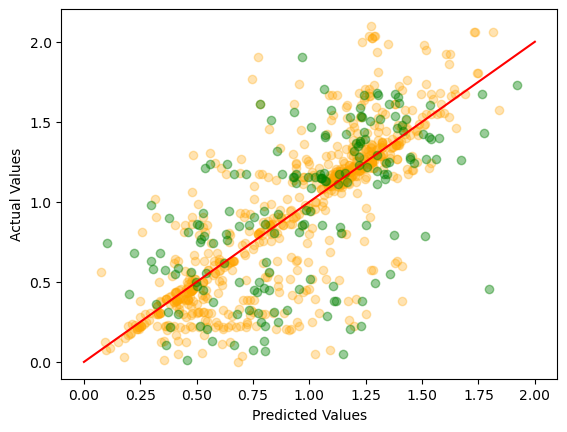

In [34]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [35]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:32:18,383] A new study created in memory with name: svm_parameter_opt
[I 2023-08-24 14:32:18,528] Trial 0 finished with value: -0.031199014491278133 and parameters: {'C': 2.157914819754843, 'epsilon': 0.16181359709954762, 'kernel': 'linear', 'degree': 2}. Best is trial 0 with value: -0.031199014491278133.
[I 2023-08-24 14:32:18,540] Trial 1 finished with value: -0.2523214127113583 and parameters: {'C': 11.5355709921917, 'epsilon': 0.34209240036038, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: -0.031199014491278133.
[I 2023-08-24 14:32:18,555] Trial 2 finished with value: -0.2523214127113583 and parameters: {'C': 16.15391221935158, 'epsilon': 0.34939896638165524, 'kernel': 'rbf', 'degree': 2}. Best is trial 0 with value: -0.031199014491278133.
[I 2023-08-24 14:32:18,668] Trial 3 finished with value: -7.173205631522455 and parameters: {'C': 10.558300203278302, 'epsilon': 0.10411293203967019, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: -0.03

Best r2:  0.4560911702345911
Best trial: {'C': 0.30457418846938605, 'epsilon': 0.012280441109187927, 'kernel': 'rbf', 'degree': 2}


In [36]:
optuna.visualization.plot_parallel_coordinate(study)

In [37]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 0.30457418846938605, 'epsilon': 0.012280441109187927, 'kernel': 'rbf', 'degree': 2}


In [38]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=0.30457418846938605, degree=2, epsilon=0.012280441109187927)

In [39]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [40]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.05064165816863905
Test RMSE:  0.06125487729092811


In [41]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.650995652581012
Test R2:  0.4264565252476644


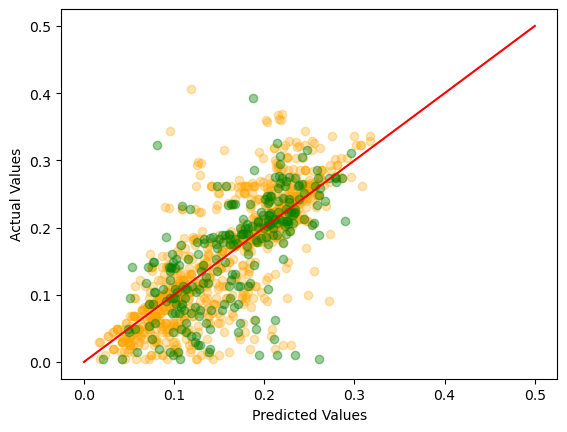

In [42]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [43]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:37:17,656] A new study created in memory with name: svm_parameter_opt
[I 2023-08-24 14:37:17,852] Trial 0 finished with value: 0.4158489860112254 and parameters: {'C': 0.36015094283076626, 'epsilon': 0.016731192163971283, 'kernel': 'linear', 'degree': 4}. Best is trial 0 with value: 0.4158489860112254.
[I 2023-08-24 14:37:17,917] Trial 1 finished with value: -0.2530403817607823 and parameters: {'C': 2.317914630361059, 'epsilon': 0.9022266912998136, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: 0.4158489860112254.
[I 2023-08-24 14:37:18,061] Trial 2 finished with value: 0.6076615388578005 and parameters: {'C': 0.9281945335274976, 'epsilon': 0.035225802657931224, 'kernel': 'poly', 'degree': 3}. Best is trial 2 with value: 0.6076615388578005.
[I 2023-08-24 14:37:18,800] Trial 3 finished with value: -19.29345506490694 and parameters: {'C': 31.712851370683577, 'epsilon': 0.03306938441494765, 'kernel': 'poly', 'degree': 5}. Best is trial 2 with value: 0.6076615

Best r2:  0.7716245885869617
Best trial: {'C': 17.535200420851496, 'epsilon': 0.26620318239293494, 'kernel': 'rbf', 'degree': 4}


In [44]:
optuna.visualization.plot_parallel_coordinate(study)

In [45]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 17.535200420851496, 'epsilon': 0.26620318239293494, 'kernel': 'rbf', 'degree': 4}


In [46]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=17.535200420851496, degree=4, epsilon=0.26620318239293494)

In [47]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [48]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.3599703572962158
Test RMSE:  0.7175756815995767


In [49]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9123661771051349
Test R2:  0.6280677215307221


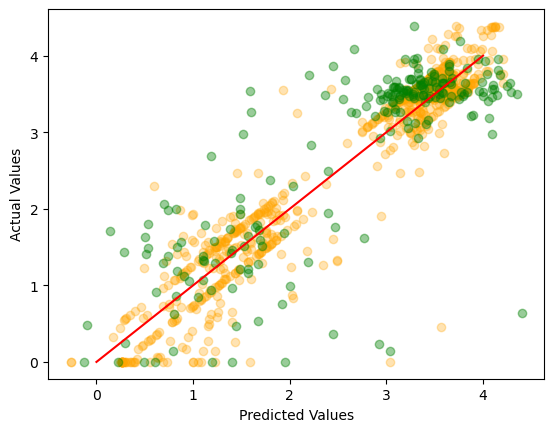

In [50]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()